<h1><center>Bank Churn Prediction Project</center></h1>
<h4><i><center>Data Analysis and Modeling by: Varun Kulkarni (kulkarnivarun@outlook.com) </center></i></h4>

## Objective
Given a Bank customer, build a neural network based classifier that can determine whether they will leave or not in the next 6 months.

## Context
Businesses like banks which provide service have to worry about problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

## Data Description
The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance etc.
Link to the Kaggle project site: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

## Tasks
1. [Reading data set and Exploratory Data Analysis (optional)](#1)
2. [Data Preparation](#2)
3. [Building and Training Artificial Neural Network (ANN)](#3)
4. [Improving Artificial Neural Network with Hyper parameter tuning](#4)
5. [Model Performance Comparison](#5)   

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Imports from scipy 
from scipy.stats import skew

# Imports from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

# Imports from TF
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, losses, layers

%matplotlib inline
sns.set(color_codes=True)
warnings.filterwarnings('ignore')
SEED=42 # seed for random state

## Reading Dataset and Exploratory Data Analysis <a class="anchor" id='1'></a>
In this section we will look at characteristics and distributions of given variables. Explore co-relations between various independent variables and how they impact the target variable.

In [2]:
# Import dataset and get familiar with the data
bank_df = pd.read_csv('bank.csv')
bank_df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


### Univariate Analysis

In [3]:
# Let's retain the original data and create a copy for analysis.
data_df = bank_df.copy(deep=True)

# Shape of the dataset
print("There are {0} records and {1} variables.".format(data_df.shape[0], data_df.shape[1]))

# Check for null values
if data_df.isnull().values.any():
    print("Null values found!")
else:
    print("No null values found.")
    
# Check for NA values
if data_df.isna().values.any():
    print("NA values found!")
else:
    print("No NA values found.")
    
# Check for duplicated values
print("Number of duplicated records: ", data_df.duplicated().sum())

There are 10000 records and 14 variables.
No null values found.
No NA values found.
Number of duplicated records:  0


In [4]:
data_df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


#### *Initial Observations*:
- 'Exited' seems to be the target variable which is binary categorical attribute.
- 'RowNumber', 'CustomerId' and 'Surname' do not provide any useful information with regards to the target variable and can be dropped.
- 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts' and 'EstimatedSalary' can be treated as numerical / continuous attributes.
- 'Geography', 'Gender', 'HasCrCard' and 'IsActiveMember' can be treated as categorical variables.

In [6]:
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
cat_cols = ['Exited', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

# Let's look at the five point summary
data_df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


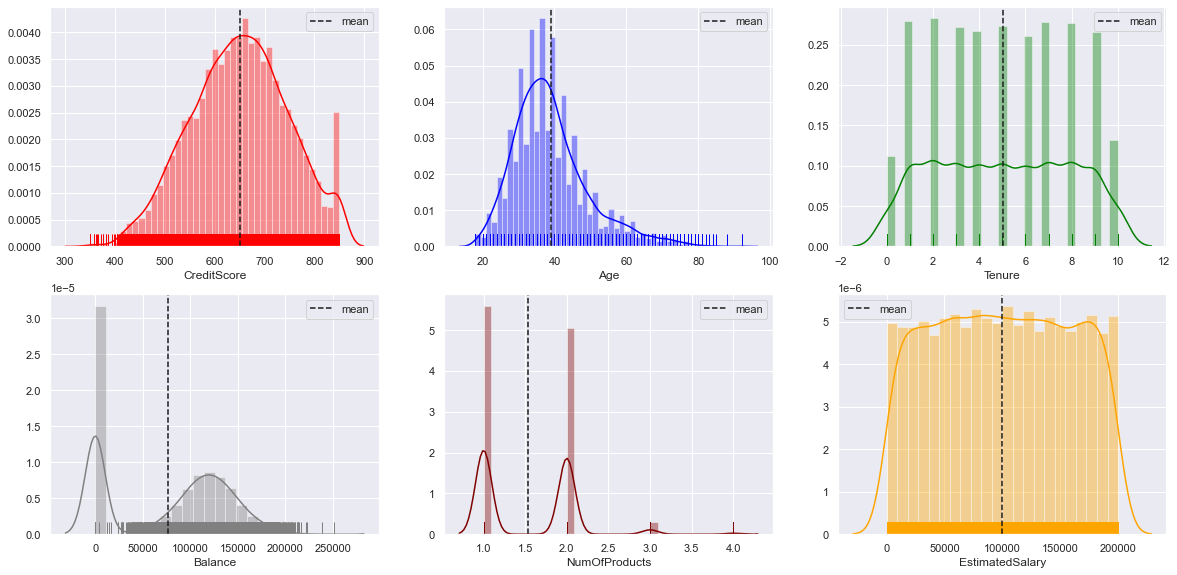

In [7]:
# Let's look at the distributions of the numerical attributes.

# Colors for plots
plot_colors = ['red', 'blue', 'green', 'grey', 'maroon', 'orange']

# Plot univariate distributions
plt.figure(figsize=(20,15))
for idx, col in enumerate(num_cols):
    plt.subplot(3, 3, idx+1)
    sns.distplot(data_df[col], color=plot_colors[idx], rug=True)
    plt.axvline(data_df[col].mean(), linestyle="dashed", label="mean", color="k")
    plt.legend(loc="best")

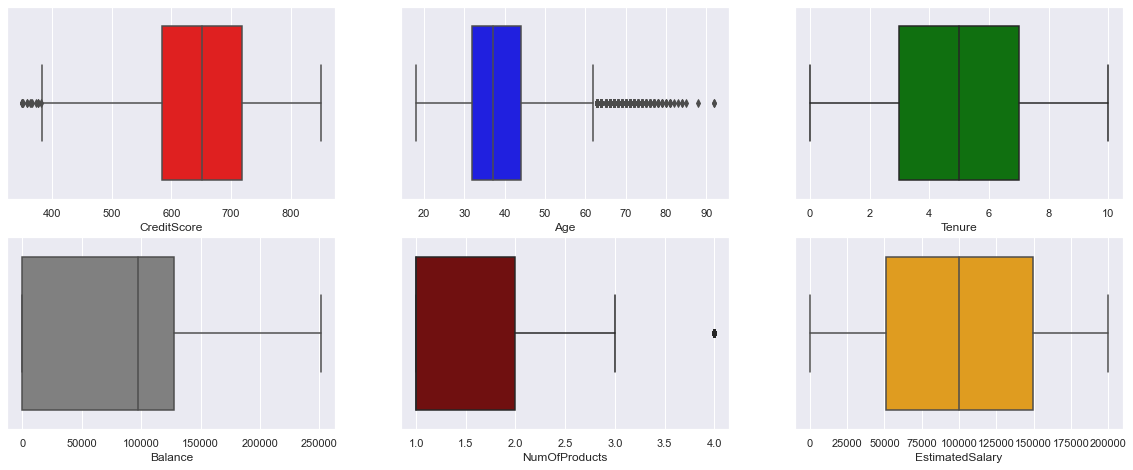

In [8]:
# Let's look at the distribution and IQRs for the attributes individually
plt.figure(figsize= (20,12))
for idx, col in enumerate(num_cols):
    plt.subplot(3, 3, idx+1)
    sns.boxplot(x=data_df[col], color=plot_colors[idx]);
    idx += 1

In [9]:
# Let's look at the skewness for variables
pd.DataFrame({'Skewness Value': [skew(data_df[var]) for var in num_cols]}, index=num_cols).T

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
Skewness Value,-0.071596,1.011169,0.01099,-0.141088,0.745456,0.002085


#### *Observations of numerical attributes* : 
- CreditScore seems to be fairly normally distributed with few outliers and very little skewness. Most of the values are between 500 and 750. Robust Scaler can used to handle the outliers.
- Age seems to have the highest skewness among all the numerical attributes and considerable amount of outliers. We can perhaps use a robust scaler to reduce the impact of outliers. Most of the values are between 20 to 60.
- Tenure has fairly normal distribution with no outliers. Most of the values are between 1 and 9 years.
- Balance seems to have two major peaks in the distribution. Considerable amount of values are zeros. The non-zero values follow fairly normal distribution. 
- NumberOfProducts seems to have two major peaks for values 1 and 2. There seems to be only four unique values for this attribute. Minor outliers observed that could be handled using robust scaler.
- EstimatedSalary seems to have fairly normal distribution with majority of values between 0 and 200K. No outliers observed.

### Multivariate Analysis

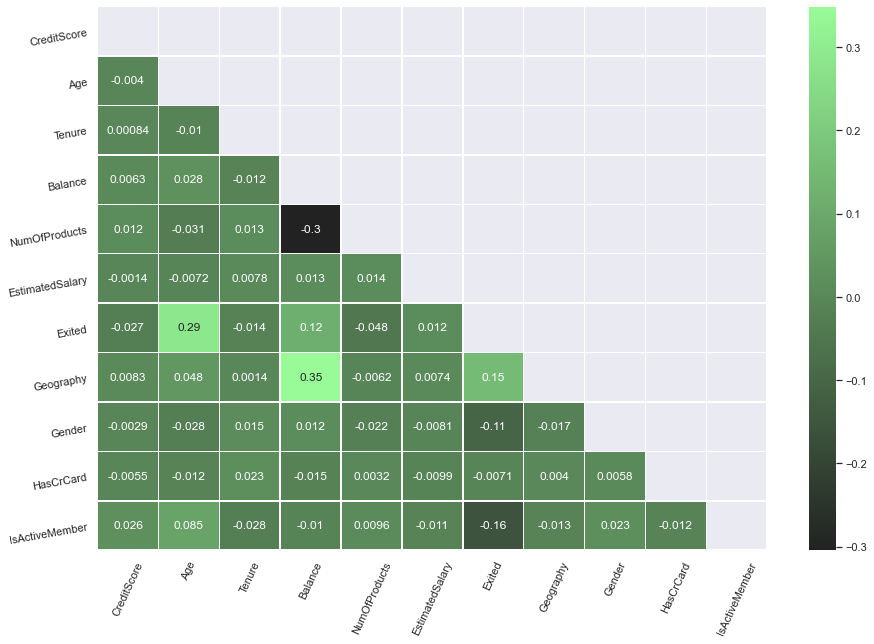

In [10]:
# Let's visualize heatmap for the correlation between attributes and target.

# Get Geography and Gender as numerical values for establising correlation
replaceStruct = {
    'Geography' : {'France': 1, 'Spain': 2, 'Germany': 3},
    'Gender' : {'Female': 1, 'Male' : 2},
}
data_num = data_df.replace(replaceStruct)

# Get correlation
corr_df = data_num[num_cols + cat_cols].corr()

# Create a mask to hide upper triangle of repeated values
upper_tri_mask = np.zeros_like(corr_df, dtype=np.bool)
upper_tri_mask[np.triu_indices_from(upper_tri_mask)] = True

# Draw the heatmap
plt.figure(figsize=(15,10))
pal = sns.dark_palette("palegreen", as_cmap=True)
pop_hmap = sns.heatmap(corr_df, mask=upper_tri_mask, annot=True, cmap=pal, linewidths=.5)
pop_hmap.set_xticklabels(pop_hmap.get_xticklabels(), rotation=65)
pop_hmap.set_yticklabels(pop_hmap.get_yticklabels(), rotation=10)
plt.show()

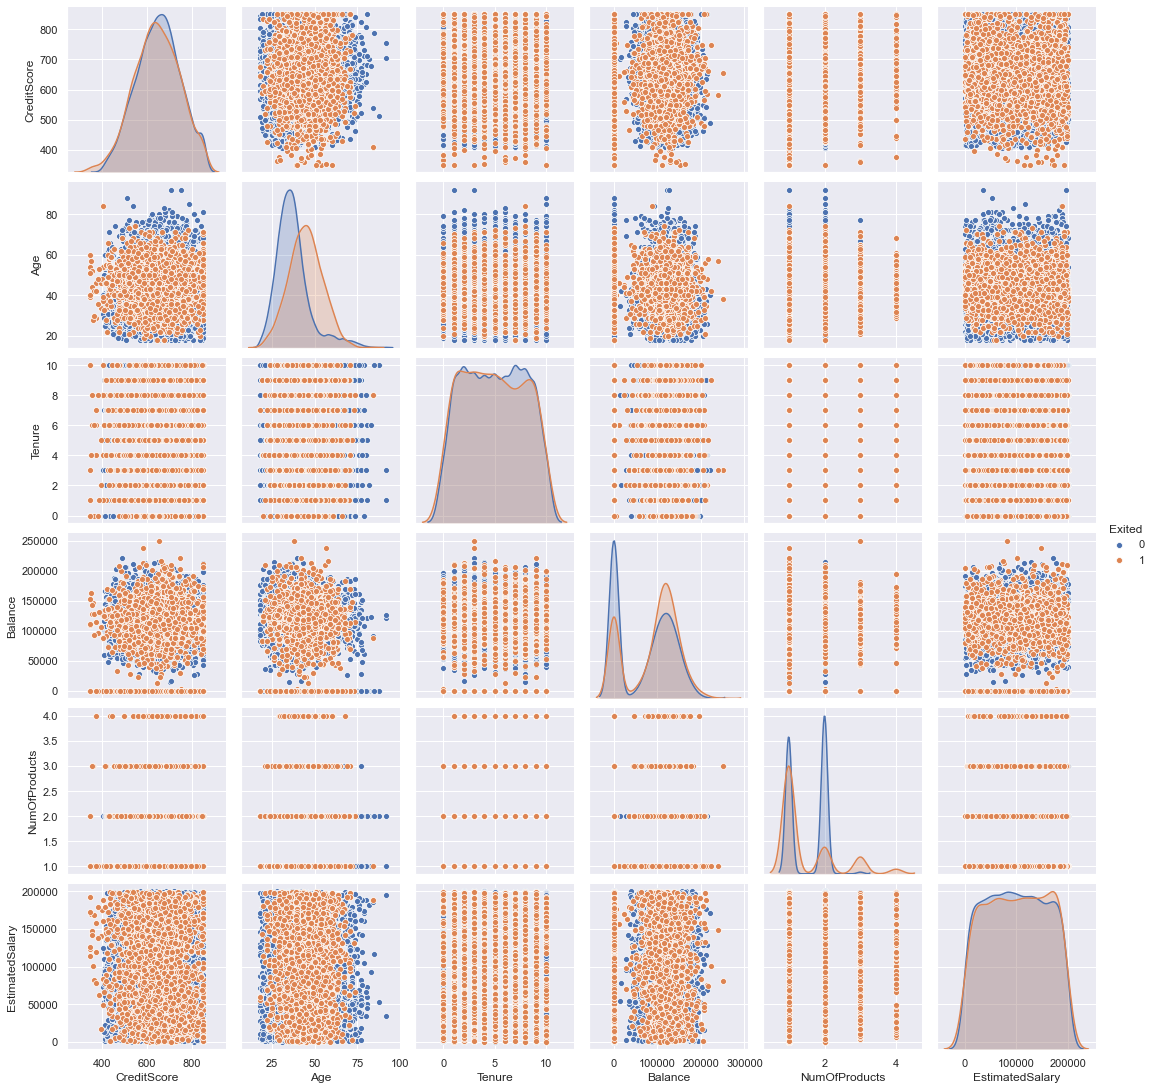

In [11]:
# Let's look at the pair wise relation ships between independent and dependent variables
sns.pairplot(data_df[num_cols + ['Exited']], diag_kind='kde', hue='Exited');

#### *Observations*:
- There is no significant correlation between the independent variables.
- There is fair amount of positive correlation between 'Age' and the target variable 'Exited'. It seems higher the age less is the chance they are exited.
- 'Balance' has positive correlation to 'Geography' but has negative correlation to 'NumberOfProducts'.
- Of course 'IsActiveMember' has negative correlation to 'Exited'.
- 'Tenure' have fairly equal amount of customers who have exited and not exited. 
- There are more customers with low balance that have not exited yet.
- There are more customers 2 products that have not exited.
- 'EstimatedSalary' has nearly equal amount of customers who have exited and not exited. 

In [12]:
# Let's look at the average of numerical variables, for target variable values 1 and 0
data_df.groupby('Exited')[num_cols].mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
Exited,,,,,,
0,651.853196,37.408389,5.033279,72745.296779,1.544267,99738.391772
1,645.351497,44.837997,4.932744,91108.539337,1.475209,101465.677531


#### *Observations*:
- Average credit score of both kind of customers (exited/not exited) is nearly the same.
- Average age of customers who have exited is higher.
- Average tenure of customer have exited is higher.
- Average balance of customers who have exited is higher.
- Average number of products owned by customers of both kinds (exited / not exited) is nearly equal.
- Average salary of customers who have exited is higher.

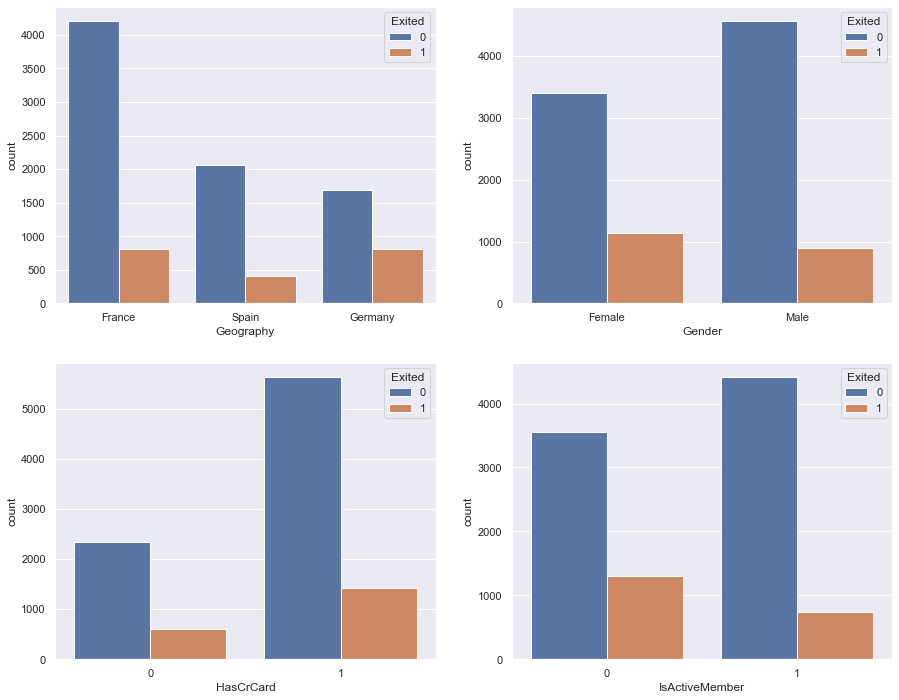

In [13]:
# Let's look at the impact of categorical variables on target variable
if 'Exited' in cat_cols:
    cat_cols.remove('Exited')
    
plt.figure(figsize=(15, 12))
idx = 1
for col in cat_cols:
    plt.subplot(2, 2, idx)
    plot = sns.countplot(data_df[col], hue=data_df.Exited);
    plot.set_xticklabels(plot.get_xticklabels());
    idx += 1

#### *Observations*: 
- Across all the categorical attributes, there are more customers who have not exited than those who have exited.
- Proportionately, France has significantly higher number of customers who have not exited compared to Spain and Germany.
- The "not exited / exited" ratio in males is higher than that of females, indicating more retention in males.
- There are more customers with credit cards that have exited.
- There are good number of customers who are not active but not have exited yet.

## Data Preparation <a class="anchor" id='2'></a>

In [14]:
# Let's drop RowNumber, CustomerId and Surname
data_clean = data_df.drop(columns=['CustomerId', 'RowNumber', 'Surname'])

# Let's one-hot encode the Geography and Gender, HasCrCard and IsActiveMember is already onehot encoded. 
oneHotEncodeCols = ['Geography', 'Gender']
data_prepared = pd.get_dummies(data_clean, columns=oneHotEncodeCols, drop_first=True)

# NOTE: Normalizing the data did not yield good performance the training accuracy plateaued at 79.3%, hence using scaling.

# Let's scale continuous attributes and handle outliers using robust scaler.
scaler = RobustScaler()
data_prepared[num_cols] = scaler.fit_transform(data_prepared[num_cols])
data_prepared

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.246269,0.416667,-0.75,-0.761480,0.0,1,1,0.011739,1,0,0,0
1,-0.328358,0.333333,-1.00,-0.104906,0.0,0,1,0.125512,0,0,1,0
2,-1.119403,0.416667,0.75,0.489346,2.0,1,0,0.139630,1,0,0,0
3,0.350746,0.166667,-1.00,-0.761480,1.0,0,0,-0.064717,0,0,0,0
4,1.477612,0.500000,-0.75,0.221806,0.0,1,1,-0.214561,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.888060,0.166667,0.00,-0.761480,1.0,1,0,-0.039876,0,0,0,1
9996,-1.014925,-0.166667,1.25,-0.312031,0.0,1,1,0.015306,0,0,0,1
9997,0.425373,-0.083333,0.50,-0.761480,0.0,0,1,-0.590615,1,0,0,0
9998,0.895522,0.416667,-0.50,-0.173319,1.0,1,0,-0.074252,1,1,0,1


In [15]:
# Separate dependent attributes
X = data_prepared.drop(columns='Exited', axis=1)
Y = data_prepared['Exited']

print("Predictor feature shape: ", X.shape)
print("Target shape: ", Y.shape)
print("")

# Train and test split, we will use 20% of train data for validation while training.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED, stratify=Y)

print("{0:0.2f}% data is in training set".format((len(x_train)/len(data_prepared)) * 100))
print("{0:0.2f}% data is in test set".format((len(x_test)/len(data_prepared)) * 100))
print("")

# Numbers from original data
orig_total = len(data_prepared)
orig_exited = len(data_prepared[data_prepared['Exited'] == 1])
orig_not_exited = len(data_prepared[data_prepared['Exited'] == 0])

# Numbers from training data
train_total = len(y_train)
train_exited = len(y_train.loc[y_train[:] == 1])
train_not_exited = len(y_train.loc[y_train[:] == 0])

# Numbers from test data
test_total = len(y_test)
test_exited = len(y_test[y_test[:] == 1])
test_not_exited = len(y_test[y_test[:] == 0])

print("Exited True Values in original set  : {0} ({1:0.2f}%)".format(orig_exited, (orig_exited/orig_total * 100)))
print("Exited False Values in original set : {0} ({1:0.2f}%)".format(orig_not_exited, (orig_not_exited/orig_total * 100)))
print("")

print("Exited True Values in train set  : {0} ({1:0.2f}%)".format(train_exited, (train_exited/train_total * 100)))
print("Exited False Values in train set : {0} ({1:0.2f}%)".format(train_not_exited, (train_not_exited/train_total * 100)))
print("")

print("Exited True Values in test set  : {0} ({1:0.2f}%)".format(test_exited, (test_exited/test_total * 100)))
print("Exited False Values in test set : {0} ({1:0.2f}%)".format(test_not_exited, (test_not_exited/test_total * 100)))
print("")

# Convert data into numpy arrays for training, validation and testing
x_train = np.array(x_train).astype('float32')
x_test  = np.array(x_test).astype('float32')
y_train = np.array(y_train).astype('float32')
y_test  = np.array(y_test).astype('float32')

print("Train data shape: ", x_train.shape)
print("Train lables shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test labels shape: ", y_test.shape)

Predictor feature shape:  (10000, 11)
Target shape:  (10000,)

80.00% data is in training set
20.00% data is in test set

Exited True Values in original set  : 2037 (20.37%)
Exited False Values in original set : 7963 (79.63%)

Exited True Values in train set  : 1630 (20.38%)
Exited False Values in train set : 6370 (79.62%)

Exited True Values in test set  : 407 (20.35%)
Exited False Values in test set : 1593 (79.65%)

Train data shape:  (8000, 11)
Train lables shape:  (8000,)
Test data shape:  (2000, 11)
Test labels shape:  (2000,)


## Building and Training Artificial Neural Network <a class="anchor" id='3'></a>

In this section we define the model architecture and train it on the training data split obtain in previous section. We use a validation split to ensure that the model is not over fitting. THen we use the test set to evaluate the model performance. FInally, we use the threshold of 0.5 to  measure the classification performance.

In [16]:
# Method to build a model
def build_model(name, input_shape, layer_activations, layer_nodes, loss, optimizer, met):
    '''Method to build tf.keras model 
    '''
    # Define empty model with name
    model = keras.models.Sequential(name=name)
    
    # Add input layer
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    # Add hidden and output layer
    for act, nodes in zip(layer_activations, layer_nodes):
        model.add(keras.layers.Dense(nodes, activation=act))
        
    # Specify model configuration
    model.compile(loss=loss, optimizer=optimizer, metrics=met)
    return model
    
    
# Let's define a method to get model performance
def get_model_perf(model, batch_size=50, threshold=0.5):
    '''
        Method to get model performance 
        model - trained model
    '''
    perf_dict = {}
    
    # Let's evaluate the models 
    results = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=False)
    perf_dict['Model eval test Loss'] = round(results[0], 3)
    perf_dict['Model eval accuracy'] = round(results[1],3)
    
    # Use trained model to predict the results 
    y_pred = model.predict(x_test)

    # Update results using 0.5 as the threshold
    y_pred_results = np.array([0.0 if val[0] < threshold else 1.0 for val in y_pred])
    
    # Let's look at the confusion matrix
    cm = confusion_matrix(y_test, y_pred_results, labels=[1, 0])
    tp, tn, fp, fn = cm[0][0], cm[1][1], cm[1][0], cm[0][1] 
    perf_dict['True Positives']  = tp
    perf_dict['False Positives'] = fp
    perf_dict['True Negatives']  = tn
    perf_dict['False Negatives'] = fn
    
    perf_dict['Test Accuracy'] = accuracy_score(y_test, y_pred_results)    
    perf_dict['Precision Score'] = precision_score(y_test, y_pred_results)
    perf_dict['Recall Score'] = recall_score(y_test, y_pred_results)
    perf_dict['F1 Score'] = f1_score(y_test, y_pred_results, average='macro')    
    
    return perf_dict

def draw_confusion_matrix(model, threshold=0.5):
    # Use trained model to predict the results 
    y_pred = model.predict(x_test)

    # Update results using 0.5 as the threshold
    y_pred_results = np.array([0.0 if val[0] < threshold else 1.0 for val in y_pred])
    
    # Let's look at the confusion matrix
    classes = ['Exited', 'Not Exited']
    cm = confusion_matrix(y_test, y_pred_results, labels=[1, 0])
    tp, tn, fp, fn = cm[0][0], cm[1][1], cm[1][0], cm[0][1] 
    
    # Plot the matrix
    plt.figure(figsize=(10,7))
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    sns.heatmap(cm_df, annot=True, linewidths=0.3, annot_kws={"fontsize":15}, fmt='g')
    plt.title('Confusion Matrix for Bank Churn Prediction')
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()

In [17]:
# Let's define a base model 
activations = [tf.nn.relu, tf.nn.relu, tf.nn.sigmoid]
hidden_nodes = [32, 16, 1]
opt = optimizers.RMSprop(learning_rate=0.001)
loss = losses.BinaryCrossentropy()

base_model = build_model(name='Bank_Churn_Predictor_Base_Model', input_shape =(11,),
                         layer_activations=activations, layer_nodes=hidden_nodes, 
                         loss=loss, optimizer=opt, met=['accuracy'])
base_model.summary()

Model: "Bank_Churn_Predictor_Base_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Let's train the base model
base_history = base_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_split=0.15, verbose=True)

Train on 6800 samples, validate on 1200 samples
Epoch 1/10
6800/6800 [==============================] - 1s 138us/sample - loss: 0.5041 - accuracy: 0.7818 - val_loss: 0.4420 - val_accuracy: 0.8167
Epoch 2/10
6800/6800 [==============================] - 0s 14us/sample - loss: 0.4401 - accuracy: 0.8050 - val_loss: 0.4206 - val_accuracy: 0.8175
Epoch 3/10
6800/6800 [==============================] - 0s 13us/sample - loss: 0.4231 - accuracy: 0.8154 - val_loss: 0.4099 - val_accuracy: 0.8233
Epoch 4/10
6800/6800 [==============================] - 0s 13us/sample - loss: 0.4133 - accuracy: 0.8212 - val_loss: 0.3992 - val_accuracy: 0.8308
Epoch 5/10
6800/6800 [==============================] - 0s 13us/sample - loss: 0.4040 - accuracy: 0.8307 - val_loss: 0.3886 - val_accuracy: 0.8383
Epoch 6/10
6800/6800 [==============================] - 0s 13us/sample - loss: 0.3949 - accuracy: 0.8372 - val_loss: 0.3785 - val_accuracy: 0.8458
Epoch 7/10
6800/6800 [==============================] - 0s 13us/sampl

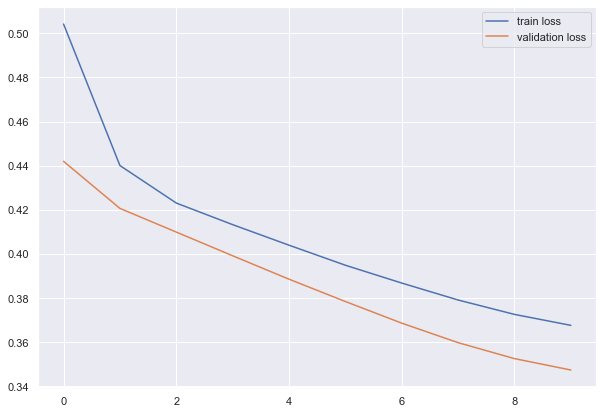

In [19]:
# Let's plot the train and validation loss to see if there's is overfitting for the base model
base_train_hist = pd.DataFrame(base_history.history)
plt.figure(figsize=(10, 7))
plt.plot(base_train_hist['loss'])
plt.plot(base_train_hist['val_loss'])
plt.legend(("train loss" , "validation loss"), loc=0)

In [20]:
# Let's look at the base model performance
base_model_perf = get_model_perf(base_model)
pd.DataFrame(base_model_perf, index=['Base Model Performance']).T

,Base Model Performance
Model eval test Loss,0.360000
Model eval accuracy,0.857000
True Positives,164.000000
False Positives,43.000000
True Negatives,1550.000000
False Negatives,243.000000
Test Accuracy,0.857000
Precision Score,0.792271
Recall Score,0.402948
F1 Score,0.724868


#### *Observations on base model*:
- The base model had about 900 parameters and is fairly shallow.
- The base model perform fairly well by achieving about 85% train and test accuracy.
- The precision score is fairly good but recall score is really low. 
- It seems this model can be improved as the training and validation loss continues to decrease.

## Improving Artificial Neural Network with Hyper parameter tuning <a class="anchor" id='4'></a>

The hyper parameters considered and their corresponding best value are described below:

1. **Learning rate**  : values considered - 0.1, 0.001, 0.0001, 1e-4, 0.002, 0.02. **Best Value Found**: 1e-4.


2. **Loss function** : Loss functions considered - Mean Squared Error (better suitable for regression problems), Categorical Cross Entropy (applicable for classifying multiple categories), Binary Cross Entropy  (suitable for binary classification). **Best Value Found** : Binary Cross Entropy


3. **Number and size of hidden layers** : 1, 2, 3, and 4 hidden layers were considered with 128, 64, 32, 16, and 8 nodes per layer. **Best Value Found** :  hidden layers with 64, 32, and 16 nodes respectively.


4. **Activation function** : ReLU, Leaky ReLU, Sigmoid, ELU and tanH were some of the activation function considered. **Best Value Found** : Leaky ReLU, ReLU, tanH and Sigmoid for hidden layers, in that order.


5. **Optimizer** : SGD, LMSprop and Adam were some of the optimizers considered. **Best Value Found** : Adam


6. **Batch size** : 8, 16, 32, 50, 64 and 100 were the values of batch sizes selected. **Best Value Found** : 50


7. **Number of epochs** : 10, 20, 50, 70, 80, and 100 epoch values were considered. **Best Value Found** : 100

In [21]:
# Based on the experimental observations described above, let's build the final model with best parameters
activations = [tf.nn.leaky_relu, tf.nn.relu, tf.nn.tanh, tf.nn.sigmoid]
hidden_nodes = [64, 32, 16, 1]
opt = optimizers.Adam(learning_rate=1e-4)
loss = losses.BinaryCrossentropy()

final_model = build_model(name='Bank_Churn_Predictor_Final_Model', input_shape =(11,),
                         layer_activations=activations, layer_nodes=hidden_nodes, 
                         loss=loss, optimizer=opt, met=['accuracy'])
final_model.summary()

Model: "Bank_Churn_Predictor_Final_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                768       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Let's train the base model
final_history = final_model.fit(x_train, y_train, batch_size=50, epochs=100, validation_split=0.15, verbose=True)

Train on 6800 samples, validate on 1200 samples
Epoch 1/100
6800/6800 [==============================] - 1s 107us/sample - loss: 0.6723 - accuracy: 0.5819 - val_loss: 0.5626 - val_accuracy: 0.8283
Epoch 2/100
6800/6800 [==============================] - 0s 28us/sample - loss: 0.5120 - accuracy: 0.7988 - val_loss: 0.4587 - val_accuracy: 0.8092
Epoch 3/100
6800/6800 [==============================] - 0s 25us/sample - loss: 0.4600 - accuracy: 0.7965 - val_loss: 0.4330 - val_accuracy: 0.8108
Epoch 4/100
6800/6800 [==============================] - 0s 26us/sample - loss: 0.4452 - accuracy: 0.8029 - val_loss: 0.4224 - val_accuracy: 0.8208
Epoch 5/100
6800/6800 [==============================] - 0s 27us/sample - loss: 0.4362 - accuracy: 0.8101 - val_loss: 0.4156 - val_accuracy: 0.8333
Epoch 6/100
6800/6800 [==============================] - 0s 29us/sample - loss: 0.4294 - accuracy: 0.8135 - val_loss: 0.4097 - val_accuracy: 0.8400
Epoch 7/100
6800/6800 [==============================] - 0s 26u

Epoch 56/100
6800/6800 [==============================] - 0s 25us/sample - loss: 0.3401 - accuracy: 0.8600 - val_loss: 0.3267 - val_accuracy: 0.8633
Epoch 57/100
6800/6800 [==============================] - 0s 25us/sample - loss: 0.3398 - accuracy: 0.8590 - val_loss: 0.3265 - val_accuracy: 0.8658
Epoch 58/100
6800/6800 [==============================] - 0s 25us/sample - loss: 0.3393 - accuracy: 0.8597 - val_loss: 0.3264 - val_accuracy: 0.8675
Epoch 59/100
6800/6800 [==============================] - 0s 25us/sample - loss: 0.3388 - accuracy: 0.8597 - val_loss: 0.3262 - val_accuracy: 0.8642
Epoch 60/100
6800/6800 [==============================] - 0s 27us/sample - loss: 0.3384 - accuracy: 0.8590 - val_loss: 0.3251 - val_accuracy: 0.8650
Epoch 61/100
6800/6800 [==============================] - 0s 27us/sample - loss: 0.3381 - accuracy: 0.8609 - val_loss: 0.3253 - val_accuracy: 0.8683
Epoch 62/100
6800/6800 [==============================] - 0s 25us/sample - loss: 0.3374 - accuracy: 0.8604

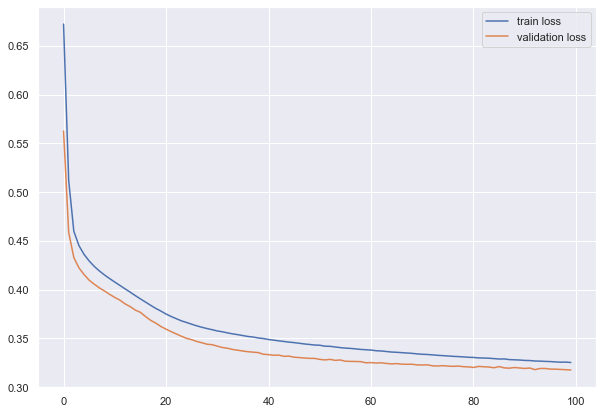

In [23]:
# Let's plot the train and validation loss to see if there's is overfitting
final_train_hist = pd.DataFrame(final_history.history)
plt.figure(figsize=(10, 7))
plt.plot(final_train_hist['loss'])
plt.plot(final_train_hist['val_loss'])
plt.legend(("train loss" , "validation loss") , loc =0)

In [24]:
# Let's look at the final model performance
final_model_perf = get_model_perf(final_model)
pd.DataFrame(final_model_perf, index=['Final Model Performance']).T

,Final Model Performance
Model eval test Loss,0.339000
Model eval accuracy,0.862000
True Positives,184.000000
False Positives,52.000000
True Negatives,1541.000000
False Negatives,223.000000
Test Accuracy,0.862500
Precision Score,0.779661
Recall Score,0.452088
F1 Score,0.745199


#### *Observations on final model*:
- The final model has over 3000 parameters and is considerably less shallow as compared to the base model.
- It seems that learning slowly (lower learning rate) with higher number of epochs resulted in better learning with no over fitting.
- Final model achieved accuracy of about 86% on training as well as test data.
- The training loss has decreased consistently over the epochs indicating improvement in model performance over training period.
- The validation loss has also decreased consistently and is lower than training loss throughout. This indicates no over fitting.
- Validation accuracy is almost equal to training accuracy.

## Model Performance Comparison  <a class="anchor" id='5'></a>

In [25]:
# Let's compare the performance of base and final model.
merged_perf_dict = {}
all_model_names = [base_model.name, final_model.name]
all_model_perf = [base_model_perf, final_model_perf]

for key in base_model_perf.keys():
    merged_perf_dict[key] = [x[key] for x in all_model_perf]

merged_perf_df = pd.DataFrame(merged_perf_dict, index=all_model_names)
merged_perf_df.T

,Bank_Churn_Predictor_Base_Model,Bank_Churn_Predictor_Final_Model
Model eval test Loss,0.360000,0.339000
Model eval accuracy,0.857000,0.862000
True Positives,164.000000,184.000000
False Positives,43.000000,52.000000
True Negatives,1550.000000,1541.000000
False Negatives,243.000000,223.000000
Test Accuracy,0.857000,0.862500
Precision Score,0.792271,0.779661
Recall Score,0.402948,0.452088
F1 Score,0.724868,0.745199


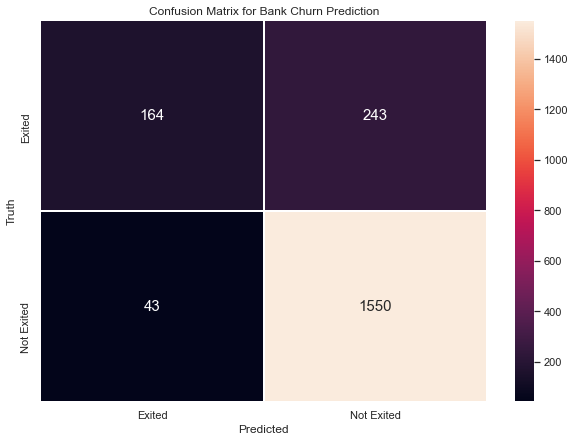

In [26]:
# Let's look at the confusion matrix of base model
draw_confusion_matrix(base_model)

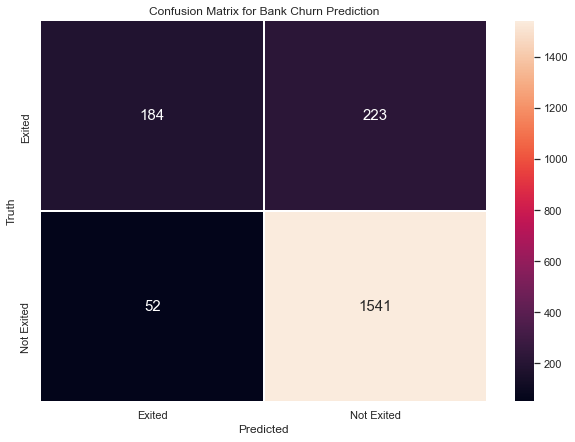

In [27]:
# Let's look at the confusion matrix of the final model.
draw_confusion_matrix(final_model)

#### *Observations*:
- Final model has better classification performance as compared to the base model. 
- F1 score for final model is higher than that of base model.
- Recall score for final model has increased indicating less false negatives.

## Conclusion

In the given case study of bank churn prediction, the Type I errors (False Positives) do not have major impact on the business. Customers who are wrongly predicted that they will exit, will stay and wouldn't have any major impact on the business revenues. 

However, Type I errors (False Negatives) will have significant impact on the business. Customers who are wrongly predicted to not exit, will exit and have an adverse impact. So, reducing false negatives is important. Our final model shows improvement in the recall score indicating reduction in false negatives. Hence, the final model is beneficial for this case study.